# 文章绘图

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import warnings
import scipy

set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

In [13]:
from pyscf import gto, scf, mp, ci, cc
from pyscf.data.nist import BOHR, HARTREE2EV, HARTREE2J
import numpy as np
from pyscf import dh
import h5py
import basis_set_exchange as bse
from scipy.spatial.transform import Rotation as R

np.set_printoptions(4, suppress=True, linewidth=180)

In [3]:
def check_sanity(mf):
    v = np.array(mf.mo_coeff.T @ mf.get_fock() @ mf.mo_coeff)
    v[np.ix_(range(mf.mol.nao), range(mf.mol.nao))] = 0
    v1 = np.abs(v).max()
    v = np.array(mf.mo_coeff.T @ mf.get_ovlp() @ mf.mo_coeff)
    v[np.ix_(range(mf.mol.nao), range(mf.mol.nao))] = 0
    v2 = np.abs(v).max()
    return v1, v2

## Ne 成对原子远距离正交不变性

### 绘图

In [4]:
mf_symm = scf.RHF(gto.Mole(atom="Ne; Ne 1 100", symmetry=True, basis="cc-pVDZ").build()).run()
mf_atom = scf.RHF(gto.Mole(atom="Ne", symmetry=True, basis="cc-pVDZ").build()).run()

converged SCF energy = -256.977551103482
converged SCF energy = -128.488775551741


In [5]:
def change_coeff(mf_symm, mf_atom, ts, orbs):
    atom_coeff = mf_atom.mo_coeff
    n, m = atom_coeff.shape
    mf = scf.RHF(gto.Mole(atom="Ne; Ne 1 100", symmetry=False, basis="cc-pVDZ").build())
    mo_coeff = mf_symm.mo_coeff
    mo_coeff[:n, 0::2] = mo_coeff[n:, 1::2] = atom_coeff
    mo_coeff[:n, 1::2] = mo_coeff[n:, 0::2] = 0
    for t, orb in zip(ts, orbs):
        mo_coeff[:n, 2*orb+0] =  np.cos(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+0] = -np.sin(t) * atom_coeff[:, orb]
        mo_coeff[:n, 2*orb+1] =  np.sin(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+1] =  np.cos(t) * atom_coeff[:, orb]
    mf.mo_coeff = mo_coeff
    mf.mo_occ = mf_symm.mo_occ
    mf.mo_energy = np.array(mf.mo_coeff.T @ mf.get_fock() @ mf.mo_coeff).diagonal()
    v1, v2 = check_sanity(mf)
    if max(v1, v2) > 1e-10:
        assert False
    return mf

In [6]:
r = dh.RIEPAConv(mf_symm, iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
e_mp2, e_cr, e_iepa, e_siepa = r["eng_corr_MP2"], r["eng_corr_MP2CR"], r["eng_corr_IEPA"], r["eng_corr_SIEPA"]

In [7]:
list_angle = np.linspace(0, 0.5 * np.pi, 120)
l1_mp2, l1_cr, l1_iepa, l1_siepa = [], [], [], []
l2_mp2, l2_cr, l2_iepa, l2_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [1]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l1_mp2.append(r["eng_corr_MP2"])
    l1_cr.append(r["eng_corr_MP2CR"])
    l1_iepa.append(r["eng_corr_IEPA"])
    l1_siepa.append(r["eng_corr_SIEPA"])
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [2]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l2_mp2.append(r["eng_corr_MP2"])
    l2_cr.append(r["eng_corr_MP2CR"])
    l2_iepa.append(r["eng_corr_IEPA"])
    l2_siepa.append(r["eng_corr_SIEPA"])
l1_mp2, l1_cr, l1_iepa, l1_siepa = np.array([l1_mp2, l1_cr, l1_iepa, l1_siepa])
l2_mp2, l2_cr, l2_iepa, l2_siepa = np.array([l2_mp2, l2_cr, l2_iepa, l2_siepa])

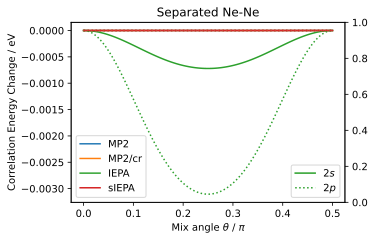

In [8]:
fig, ax = plt.subplots(figsize=(5, 3.5))
for l, c, label in zip(
        [l1_mp2, l1_cr, l1_iepa, l1_siepa],
        ["C0", "C1", "C2", "C3"],
        ["MP2", "MP2/cr", "IEPA", "sIEPA"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle="-", label=label)
for l, c in zip([l2_mp2, l2_cr, l2_iepa, l2_siepa], ["C0", "C1", "C2", "C3"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle=":")
ax.set_xlabel(r"Mix angle $\theta$ / $\pi$")
ax.set_ylabel(r"Correlation Energy Change / eV")
ax.set_title(r"Separated Ne-Ne")

fig.tight_layout()
ax.legend(loc="lower left")
ax2 = ax.twinx()
ax2.legend(handles=[ax.get_children()[2], ax.get_children()[6]], labels=["$2s$", "$2p$"], loc="lower right")
fig.savefig("invar-sep-Ne.pdf", transparent=True)

In [17]:
0.004 / HARTREE2EV * 627.51

0.09224226939984441

In [19]:
e_mp2 - e_siepa

-1.1102230246251565e-16

In [22]:
ci.CISD(scf.RHF(gto.Mole(atom="Ne; Ne 1 100", symmetry=True, basis="cc-pVDZ").build()).run()).run().e_corr

converged SCF energy = -256.977551103482
E(RCISD) = -257.341812547746  E_corr = -0.3642614442644732


-0.36426144426447316

In [23]:
ci.CISD(scf.RHF(gto.Mole(atom="Ne", symmetry=True, basis="cc-pVDZ").build()).run()).run().e_corr

converged SCF energy = -128.488775551741
E(RCISD) = -128.675426944895  E_corr = -0.18665139315417


-0.18665139315417

In [25]:
(-0.36426144426447316 - 2 * -0.18665139315417) * HARTREE2EV

0.24602744849451696

### 能量表

In [9]:
e_mp2, e_cr, e_iepa, e_siepa

(-0.37513437373654784,
 -0.3724872171986148,
 -0.37489054943162814,
 -0.37513437373654773)

In [10]:
l1_mp2[0], l1_cr[0], l1_iepa[0], l1_siepa[0]

(-0.3751343717147331,
 -0.3724872152290715,
 -0.3746475770878868,
 -0.37513437171473274)

In [11]:
(
    + np.array([l1_mp2[0], l1_cr[0], l1_iepa[0], l1_siepa[0]])
    - np.array([e_mp2, e_cr, e_iepa, e_siepa])
) * HARTREE2EV * 1e8

array([     5.5016,      5.3594, 661161.4238,      5.5016])

In [12]:
(l1_mp2[0] - dh.RIEPAConv(mf_atom).run().results["eng_corr_MP2"] * 2) * HARTREE2EV

5.5015978885979986e-08

## N2 成对分子远距离正交不变性

In [185]:
mf_symm = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 2; N 0 0 100; N 0 0 102", symmetry=True, basis="cc-pVDZ").build()).run()
mf_atom = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 2", symmetry=True, basis="cc-pVDZ").build()).run()

converged SCF energy = -216.661165507312
converged SCF energy = -108.33058275366


In [186]:
def change_coeff(mf_symm, mf_atom, ts, orbs):
    atom_coeff = mf_atom.mo_coeff
    n, m = atom_coeff.shape
    mf = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 2; N 0 0 100; N 0 0 102", symmetry=True, basis="cc-pVDZ").build())
    mo_coeff = mf_symm.mo_coeff.copy()
    mo_coeff[:n, 0::2] = mo_coeff[n:, 1::2] = atom_coeff
    mo_coeff[:n, 1::2] = mo_coeff[n:, 0::2] = 0
    for t, orb in zip(ts, orbs):
        mo_coeff[:n, 2*orb+0] =  np.cos(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+0] = -np.sin(t) * atom_coeff[:, orb]
        mo_coeff[:n, 2*orb+1] =  np.sin(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+1] =  np.cos(t) * atom_coeff[:, orb]
    mf.mo_coeff = mo_coeff
    mf.mo_occ = mf_symm.mo_occ
    mf.mo_energy = np.array(mf.mo_coeff.T @ mf.get_fock() @ mf.mo_coeff).diagonal()
    v1, v2 = check_sanity(mf)
    if max(v1, v2) > 1e-10:
        assert False
    return mf

In [187]:
r = dh.RIEPAConv(mf_symm, iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
e_mp2, e_cr, e_iepa, e_siepa = r["eng_corr_MP2"], r["eng_corr_MP2CR"], r["eng_corr_IEPA"], r["eng_corr_SIEPA"]

In [197]:
list_angle = np.linspace(0, 0.5 * np.pi, 120)
l1_mp2, l1_cr, l1_iepa, l1_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [4]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l1_mp2.append(r["eng_corr_MP2"])
    l1_cr.append(r["eng_corr_MP2CR"])
    l1_iepa.append(r["eng_corr_IEPA"])
    l1_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [5]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l2_mp2.append(r["eng_corr_MP2"])
    l2_cr.append(r["eng_corr_MP2CR"])
    l2_iepa.append(r["eng_corr_IEPA"])
    l2_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = np.array([l2_mp2, l2_cr, l2_iepa, l2_siepa])

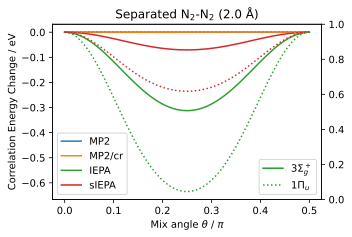

In [200]:
fig, ax = plt.subplots(figsize=(5, 3.5))
for l, c, label in zip(
        [l1_mp2, l1_cr, l1_iepa, l1_siepa],
        ["C0", "C1", "C2", "C3"],
        ["MP2", "MP2/cr", "IEPA", "sIEPA"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle="-", label=label)
for l, c in zip([l2_mp2, l2_cr, l2_iepa, l2_siepa], ["C0", "C1", "C2", "C3"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle=":")
ax.set_xlabel(r"Mix angle $\theta$ / $\pi$")
ax.set_ylabel(r"Correlation Energy Change / eV")
ax.set_title(r"Separated N$_2$-N$_2$ (2.0 Å)")
ax2 = ax.twinx()
ax2.legend(handles=[ax.get_children()[2], ax.get_children()[6]], labels=[r"$3\Sigma_g^+$", "$1\Pi_u$"], loc="lower right")

fig.tight_layout()
ax.legend(loc="lower left")
fig.savefig("invar-sep-N2-2.pdf", transparent=True)

In [70]:
(l1_iepa[60] - l1_iepa[0]) * HARTREE2EV

-0.6345920281341209

In [201]:
mf_symm = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 1.077; N 0 0 100; N 0 0 101.077", symmetry=True, basis="cc-pVDZ").build()).run()
mf_atom = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 1.077", symmetry=True, basis="cc-pVDZ").build()).run()

converged SCF energy = -217.911116922308
converged SCF energy = -108.955558461171


In [203]:
def change_coeff(mf_symm, mf_atom, ts, orbs):
    atom_coeff = mf_atom.mo_coeff
    n, m = atom_coeff.shape
    mf = scf.RHF(gto.Mole(atom="N 0 0 0; N 0 0 1.077; N 0 0 100; N 0 0 101.077", symmetry=True, basis="cc-pVDZ").build())
    mo_coeff = mf_symm.mo_coeff.copy()
    mo_coeff[:n, 0::2] = mo_coeff[n:, 1::2] = atom_coeff
    mo_coeff[:n, 1::2] = mo_coeff[n:, 0::2] = 0
    for t, orb in zip(ts, orbs):
        mo_coeff[:n, 2*orb+0] =  np.cos(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+0] = -np.sin(t) * atom_coeff[:, orb]
        mo_coeff[:n, 2*orb+1] =  np.sin(t) * atom_coeff[:, orb]
        mo_coeff[n:, 2*orb+1] =  np.cos(t) * atom_coeff[:, orb]
    mf.mo_coeff = mo_coeff
    mf.mo_occ = mf_symm.mo_occ
    mf.mo_energy = np.array(mf.mo_coeff.T @ mf.get_fock() @ mf.mo_coeff).diagonal()
    v1, v2 = check_sanity(mf)
    if max(v1, v2) > 1e-10:
        assert False
    return mf

In [204]:
r = dh.RIEPAConv(mf_symm, iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
e_mp2, e_cr, e_iepa, e_siepa = r["eng_corr_MP2"], r["eng_corr_MP2CR"], r["eng_corr_IEPA"], r["eng_corr_SIEPA"]

In [205]:
list_angle = np.linspace(0, 0.5 * np.pi, 120)
l1_mp2, l1_cr, l1_iepa, l1_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [4]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l1_mp2.append(r["eng_corr_MP2"])
    l1_cr.append(r["eng_corr_MP2CR"])
    l1_iepa.append(r["eng_corr_IEPA"])
    l1_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, mf_atom, [angle], [5]), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l2_mp2.append(r["eng_corr_MP2"])
    l2_cr.append(r["eng_corr_MP2CR"])
    l2_iepa.append(r["eng_corr_IEPA"])
    l2_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = np.array([l2_mp2, l2_cr, l2_iepa, l2_siepa])

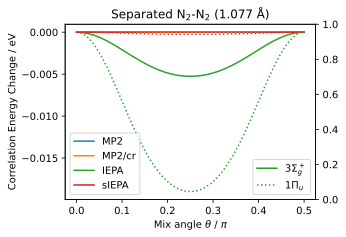

In [206]:
fig, ax = plt.subplots(figsize=(5, 3.5))
for l, c, label in zip(
        [l1_mp2, l1_cr, l1_iepa, l1_siepa],
        ["C0", "C1", "C2", "C3"],
        ["MP2", "MP2/cr", "IEPA", "sIEPA"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle="-", label=label)
for l, c in zip([l2_mp2, l2_cr, l2_iepa, l2_siepa], ["C0", "C1", "C2", "C3"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle=":")
ax.set_xlabel(r"Mix angle $\theta$ / $\pi$")
ax.set_ylabel(r"Correlation Energy Change / eV")
ax.set_title(r"Separated N$_2$-N$_2$ (1.077 Å)")
ax2 = ax.twinx()
ax2.legend(handles=[ax.get_children()[2], ax.get_children()[6]], labels=[r"$3\Sigma_g^+$", "$1\Pi_u$"], loc="lower right")

fig.tight_layout()
ax.legend(loc="lower left")
fig.savefig("invar-sep-N2-1.pdf", transparent=True)

## C4H4 Td 点群轨道旋转

In [212]:
def get_mol(dist, symm=False):
    n1 = np.sqrt(2/3) / 4
    n2 = np.sqrt(2/3) / 4 * 3
    a1 = 1 / np.sqrt(3)
    a2 = 1 / 2
    a3 = 1 / np.sqrt(3) / 2
    atom = f"""
    C 0 0 {n2*dist}
    C {a1*dist} 0 {-n1*dist}
    C {-a3*dist} {a2*dist} {-n1*dist}
    C {-a3*dist} {-a2*dist} {-n1*dist}
    H 0 0 {n2*2*dist}
    H {a1*2*dist} 0 {-n1*2*dist}
    H {-a3*2*dist} {a2*2*dist} {-n1*2*dist}
    H {-a3*2*dist} {-a2*2*dist} {-n1*2*dist}
    """
    return gto.Mole(atom=atom, basis="cc-pVDZ", symmetry=symm).build()

In [213]:
mf_symm = scf.RHF(get_mol(2, symm=True)).run()
mol_symm = get_mol(2, symm=True)
mol = get_mol(2)

converged SCF energy = -153.128720970676


In [214]:
r = dh.RIEPAConv(mf_symm, iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
e_mp2, e_cr, e_iepa, e_siepa = r["eng_corr_MP2"], r["eng_corr_MP2CR"], r["eng_corr_IEPA"], r["eng_corr_SIEPA"]

In [215]:
def change_coeff_t2(mf, angle):
    r = R.from_rotvec([0, 0, angle])
    rm = r.as_matrix()
    
    m = scf.RHF(mol)
    m.mo_occ = mf.mo_occ
    mo_coeff = np.array(mf.mo_coeff).copy()
    for n in range(mo_coeff.shape[0]):
        mo_coeff[n, 9:12] = rm @ mo_coeff[n, 9:12]
    m.mo_coeff = mo_coeff
    m.mo_energy = np.diagonal(mo_coeff.T @ m.get_fock() @ mo_coeff)
    return m

In [216]:
def change_coeff_e(mf, angle):
    rm = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    m = scf.RHF(mol)
    m.mo_occ = mf.mo_occ
    mo_coeff = np.array(mf.mo_coeff).copy()
    for n in range(mo_coeff.shape[0]):
        mo_coeff[n, 12:14] = rm @ mo_coeff[n, 12:14]
    m.mo_coeff = mo_coeff
    m.mo_energy = np.diagonal(mo_coeff.T @ m.get_fock() @ mo_coeff)
    return m

In [217]:
list_angle = np.linspace(0, 0.5 * np.pi, 120)
l1_mp2, l1_cr, l1_iepa, l1_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff_t2(mf_symm, angle), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l1_mp2.append(r["eng_corr_MP2"])
    l1_cr.append(r["eng_corr_MP2CR"])
    l1_iepa.append(r["eng_corr_IEPA"])
    l1_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff_e(mf_symm, angle), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l2_mp2.append(r["eng_corr_MP2"])
    l2_cr.append(r["eng_corr_MP2CR"])
    l2_iepa.append(r["eng_corr_IEPA"])
    l2_siepa.append(r["eng_corr_SIEPA"])
l2_mp2, l2_cr, l2_iepa, l2_siepa = np.array([l2_mp2, l2_cr, l2_iepa, l2_siepa])

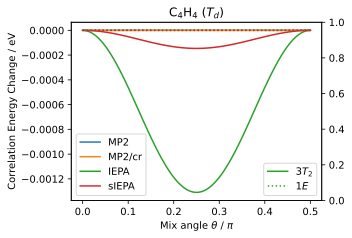

In [225]:
fig, ax = plt.subplots(figsize=(5, 3.5))
for l, c, label in zip(
        [l1_mp2, l1_cr, l1_iepa, l1_siepa],
        ["C0", "C1", "C2", "C3"],
        ["MP2", "MP2/cr", "IEPA", "sIEPA"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle="-", label=label)
for l, c in zip([l2_mp2, l2_cr, l2_iepa, l2_siepa], ["C0", "C1", "C2", "C3"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle=":")
ax.set_xlabel(r"Mix angle $\theta$ / $\pi$")
ax.set_ylabel(r"Correlation Energy Change / eV")
ax.set_title(r"C${}_4$H${}_4$ ($T_d$)")
ax2 = ax.twinx()
ax2.legend(handles=[ax.get_children()[2], ax.get_children()[6]], labels=[r"$3 T_2$", "$1 E$"], loc="lower right")

fig.tight_layout()
ax.legend(loc="lower left")
fig.savefig("invar-sep-C4H4-1.pdf", transparent=True)

In [226]:
(l1_iepa[60] - l1_iepa[0]) * HARTREE2EV

-0.001308903483473164

## CO 不同对称性轨道旋转

In [256]:
mol = gto.Mole(atom="C; O 1 1.82116696109", basis="cc-pVDZ", verbose=0).build()
mol_symm = gto.Mole(atom="C; O 1 1.82116696109", basis="cc-pVDZ", symmetry=True, verbose=0).build()

In [257]:
mf_symm = scf.RHF(mol_symm).run().newton().run(converged=True, conv_tol=1e-13, conv_tol_grad=1e-11)

In [258]:
def change_coeff(mf, angle):
    rm = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    m = scf.RHF(mol)
    m.mo_occ = mf.mo_occ
    mo_coeff = np.array(mf.mo_coeff).copy()
    for n in range(mo_coeff.shape[0]):
        mo_coeff[n, 5:7] = rm @ mo_coeff[n, 5:7]
    m.mo_coeff = mo_coeff
    m.mo_energy = np.diagonal(mo_coeff.T @ m.get_fock() @ mo_coeff)
    return m

In [260]:
mf_symm.mo_energy[4] - mf_symm.mo_energy[6]

-4.8638315597315795e-12

In [263]:
list_angle = np.linspace(0, 0.5 * np.pi, 120)
l1_mp2, l1_cr, l1_iepa, l1_siepa = [], [], [], []
for angle in list_angle:
    r = dh.RIEPAConv(change_coeff(mf_symm, angle), iepa_schemes=["MP2", "MP2cr", "IEPA", "sIEPA"]).run().results
    l1_mp2.append(r["eng_corr_MP2"])
    l1_cr.append(r["eng_corr_MP2CR"])
    l1_iepa.append(r["eng_corr_IEPA"])
    l1_siepa.append(r["eng_corr_SIEPA"])
l1_mp2, l1_cr, l1_iepa, l1_siepa = np.array([l1_mp2, l1_cr, l1_iepa, l1_siepa])

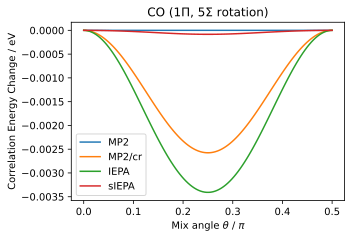

In [267]:
fig, ax = plt.subplots(figsize=(5, 3.5))
for l, c, label in zip(
        [l1_mp2, l1_cr, l1_iepa, l1_siepa],
        ["C0", "C1", "C2", "C3"],
        ["MP2", "MP2/cr", "IEPA", "sIEPA"]):
    ax.plot(list_angle / np.pi, (l - l[0]) * HARTREE2EV, color=c, linestyle="-", label=label)
ax.set_xlabel(r"Mix angle $\theta$ / $\pi$")
ax.set_ylabel(r"Correlation Energy Change / eV")
ax.set_title(r"CO ($1 \Pi$, $5 \Sigma$ rotation)")

fig.tight_layout()
ax.legend(loc="lower left")
fig.savefig("invar-sep-CO.pdf", transparent=True)

In [268]:
mf_symm.mo_energy

array([-20.6128, -11.5186,  -1.206 ,  -0.8038,  -0.4643,  -0.4643,  -0.4643,  -0.0128,  -0.0128,   0.1592,   0.6089,   0.647 ,   0.647 ,   0.7155,   1.1765,   1.1765,   1.2945,
         1.3063,   1.3063,   1.4323,   1.4323,   1.478 ,   1.9989,   2.9922,   2.9922,   3.0286,   3.0286,   3.2677])